<a href="https://colab.research.google.com/github/Ali-Saud/ML-in-PE/blob/master/nasdaq-Nestor-delivered-file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1709]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import math

In [1710]:
df = pd.read_csv('nasdaq-21-y.csv')
cols = list(df)[1:6]

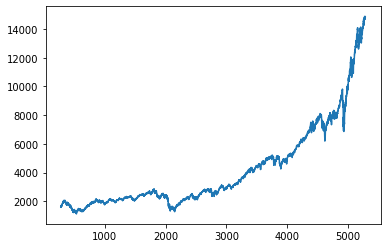

In [1711]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

df_for_plot=df_for_training['Close'].tail(5000)
df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

Prediction *Variables*:

In [1712]:
last_original_date = '2021-08-13'

In [1713]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

In [1714]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []


#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (5277, 5, 5).
trainY shape == (5277, 1).


In [1715]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 5, 64)             17920     
_________________________________________________________________
lstm_57 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/8
75/75 [==============================] - 4s 14ms/step - loss: 0.0941 - val_loss: 1.0913
Epoch 2/8
75/75 [==============================] - 1s 9ms/step - loss: 0.0153 - val_loss: 0.3117
Epoch 3/8
75/75 [==============================] - 1s 9ms/step - loss: 0.0120 - val_loss: 0.1251
Epoch 4/8
75/75 [==============================] - 1s 9ms/step - loss: 0.0121 - val_loss: 0.2812
Epoch 5/8
75/75 [==============================] - 1s 9ms/step - loss: 0.0120 - val_loss: 0.0071
Epoch 6/8
75/75 [==============================] - 1s 9ms/step - loss: 0.0109 - val_loss: 0.0056
Epoch 7/8
75/75 [==============================] - 1s 9ms/step - loss: 0.0110 - val_loss: 0.0058
Epoch 8/8
75/75 [==============================] - 1s 9ms/step - loss: 0.0102 - val_loss: 0.0108


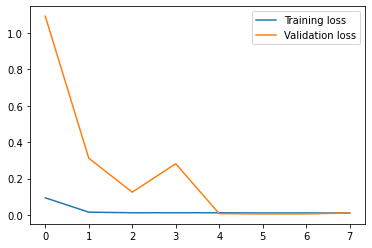

In [1716]:
# fit the model
history = model.fit(trainX, trainY, epochs=8, batch_size=64, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [1717]:
print(history.history['loss'])
#print(history.history['acc'])

[0.09406542032957077, 0.015270830132067204, 0.012015830725431442, 0.012088553048670292, 0.012025529518723488, 0.010869237594306469, 0.01100065466016531, 0.010217451490461826]


In [1718]:
#loss, acc = new_model.evaluate(trainX, trainY, verbose=2)
#print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

## Define Days in the past used to predict how many days in future:

In [1719]:
n_past = 5  # best value is 5 days for best accuracy
n_days_for_prediction= 20 # For best directional accuracy don't put > 20

In [1720]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
train_dates = pd.to_datetime(df['Date'])
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.


predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2021-08-09 00:00:00', freq='C'), Timestamp('2021-08-10 00:00:00', freq='C'), Timestamp('2021-08-11 00:00:00', freq='C'), Timestamp('2021-08-12 00:00:00', freq='C'), Timestamp('2021-08-13 00:00:00', freq='C'), Timestamp('2021-08-16 00:00:00', freq='C'), Timestamp('2021-08-17 00:00:00', freq='C'), Timestamp('2021-08-18 00:00:00', freq='C'), Timestamp('2021-08-19 00:00:00', freq='C'), Timestamp('2021-08-20 00:00:00', freq='C'), Timestamp('2021-08-23 00:00:00', freq='C'), Timestamp('2021-08-24 00:00:00', freq='C'), Timestamp('2021-08-25 00:00:00', freq='C'), Timestamp('2021-08-26 00:00:00', freq='C'), Timestamp('2021-08-27 00:00:00', freq='C'), Timestamp('2021-08-30 00:00:00', freq='C'), Timestamp('2021-08-31 00:00:00', freq='C'), Timestamp('2021-09-01 00:00:00', freq='C'), Timestamp('2021-09-02 00:00:00', freq='C'), Timestamp('2021-09-03 00:00:00', freq='C')]


In [1721]:
prediction_period = pd.to_datetime(predict_period_dates)
#prediction_period

In [1722]:
s =prediction_period[0]
s = s.strftime('%Y-%m-%d')
s

'2021-08-09'

In [1723]:
e =prediction_period[-1]
e = e.strftime('%Y-%m-%d')
e

'2021-09-03'

In [1724]:
pred_dates[-1]

Timestamp('2021-08-27 00:00:00')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


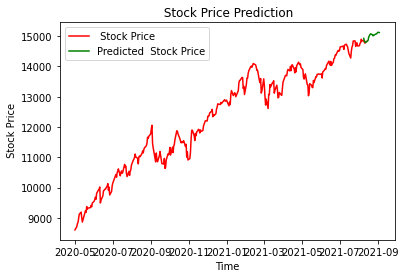

In [1725]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

#sns.lineplot(original['Date'], original['Close'])
#sns.lineplot(df_forecast['Date'], df_forecast['Close'])

plt.plot(original['Date'], original['Close'], color = 'red', label = ' Stock Price')
plt.plot(df_forecast['Date'], df_forecast['Close'] , color = 'green', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [1726]:
original.tail(10)

,Date,Close
5272,2021-08-02,14681.070313
5273,2021-08-03,14761.290039
5274,2021-08-04,14780.530273
5275,2021-08-05,14895.120117
5276,2021-08-06,14835.759766
5277,2021-08-09,14860.179688
5278,2021-08-10,14788.089844
5279,2021-08-11,14765.139648
5280,2021-08-12,14816.259766
5281,2021-08-13,14822.900391


In [1727]:
df_forecast

,Date,Close
0,2021-08-09,14922.597656
1,2021-08-10,14833.162109
2,2021-08-11,14804.204102
3,2021-08-12,14789.680664
4,2021-08-13,14799.984375
5,2021-08-16,14858.670898
6,2021-08-17,14969.175781
7,2021-08-18,15009.974609
8,2021-08-19,15045.002930
9,2021-08-20,15073.643555


In [1728]:
#p = df_forecast['Date']

In [1729]:
#p = np.array(p)

In [1730]:
#p = pd.to_datetime(p)
#p

In [1731]:
#pred_start = p[0]
#pred_start

In [1732]:
#pred_end = p[-1]
#pred_end

In [1733]:
original_open = original.loc[original['Date'] >= s]

original_open

,Date,Close
5277,2021-08-09,14860.179688
5278,2021-08-10,14788.089844
5279,2021-08-11,14765.139648
5280,2021-08-12,14816.259766
5281,2021-08-13,14822.900391


In [1734]:
original_open = original_open.loc[original_open['Date'] <= e]
original_open

,Date,Close
5277,2021-08-09,14860.179688
5278,2021-08-10,14788.089844
5279,2021-08-11,14765.139648
5280,2021-08-12,14816.259766
5281,2021-08-13,14822.900391


In [1735]:

df_forecast = df_forecast.loc[df_forecast['Date'] >= s]
df_forecast

,Date,Close
0,2021-08-09,14922.597656
1,2021-08-10,14833.162109
2,2021-08-11,14804.204102
3,2021-08-12,14789.680664
4,2021-08-13,14799.984375
5,2021-08-16,14858.670898
6,2021-08-17,14969.175781
7,2021-08-18,15009.974609
8,2021-08-19,15045.002930
9,2021-08-20,15073.643555


In [1736]:
df_forecast = df_forecast.loc[df_forecast['Date'] <= last_original_date]
df_forecast

,Date,Close
0,2021-08-09,14922.597656
1,2021-08-10,14833.162109
2,2021-08-11,14804.204102
3,2021-08-12,14789.680664
4,2021-08-13,14799.984375


In [1737]:
direction = []
a = 14821.030273
for i in df_forecast['Close']:
  if (i==a):
    dir = 'Neutral'
    #print(dir)
  if (i< a):
    dir = 'Down'
    #print(dir)
  else:
    dir = 'Up'
    #print(dir)
  a = i
  direction.append(dir)
#direction
  

In [1738]:
original_open = original_open['Close']
original_open = np.array(original_open)
original_open

array([14860.179688, 14788.089844, 14765.139648, 14816.259766,
       14822.900391])

In [1739]:
df_forecast['Actual Price'] = original_open
df_forecast

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Close,Actual Price
0,2021-08-09,14922.597656,14860.179688
1,2021-08-10,14833.162109,14788.089844
2,2021-08-11,14804.204102,14765.139648
3,2021-08-12,14789.680664,14816.259766
4,2021-08-13,14799.984375,14822.900391


In [1740]:
df_forecast['Direction']= direction
df_forecast

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Close,Actual Price,Direction
0,2021-08-09,14922.597656,14860.179688,Up
1,2021-08-10,14833.162109,14788.089844,Down
2,2021-08-11,14804.204102,14765.139648,Down
3,2021-08-12,14789.680664,14816.259766,Down
4,2021-08-13,14799.984375,14822.900391,Up


In [1741]:
Accuracy = df_forecast['Close']/df_forecast['Actual Price']
Accuracy=np.array(Accuracy)
Accuracy

array([1.00420035, 1.00304788, 1.00264572, 0.99820609, 0.99845401])

In [1742]:
df_forecast['Accuracy'] = Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1743]:
pred_first_dates = pd.to_datetime(predict_period_dates)
pred_first_dates

DatetimeIndex(['2021-08-09', '2021-08-10', '2021-08-11', '2021-08-12',
               '2021-08-13', '2021-08-16', '2021-08-17', '2021-08-18',
               '2021-08-19', '2021-08-20', '2021-08-23', '2021-08-24',
               '2021-08-25', '2021-08-26', '2021-08-27', '2021-08-30',
               '2021-08-31', '2021-09-01', '2021-09-02', '2021-09-03'],
              dtype='datetime64[ns]', freq=None)

In [1744]:
original_open

array([14860.179688, 14788.089844, 14765.139648, 14816.259766,
       14822.900391])

In [1745]:
df_forecast['Close'][0]

14922.598

In [1746]:
actual_direction = []
#a = predict_period_dates[0]#14821.030273
a = df_forecast['Close'][0]
b = original_open[0]
for i in original_open:
  #print(i,a)
  if (i==bin):
    dir = 'Neutral'
    #print(dir)
  if (i< b):
    dir = 'Down'
    #print(dir)
  else:
    dir = 'Up'
    #print(dir)
  b = i
  actual_direction.append(dir)
#actual_direction

In [1747]:
df_forecast['Actual Direction'] = actual_direction
df_forecast

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Close,Actual Price,Direction,Accuracy,Actual Direction
0,2021-08-09,14922.597656,14860.179688,Up,1.004200,Up
1,2021-08-10,14833.162109,14788.089844,Down,1.003048,Down
2,2021-08-11,14804.204102,14765.139648,Down,1.002646,Down
3,2021-08-12,14789.680664,14816.259766,Down,0.998206,Up
4,2021-08-13,14799.984375,14822.900391,Up,0.998454,Up


# Directional Accuracy:



In [1748]:
hits =0
misses=0
for i in range(1, len(df_forecast)):
  if (df_forecast['Direction'][i] == df_forecast['Actual Direction'][i]):
    hits = hits +1
    #print('Hit', hits)
  else:
    misses = misses +1
    #print('Miss', misses)
accuracy_overall = hits/(hits+misses)
print('Overall Accuracy :' , accuracy_overall)

Overall Accuracy : 0.75
